In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
tasa = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/filtered_severity_final_new_mask.nc').sel(time=slice('1982', '2018'), longitude=slice(144.0, 149.0), latitude=slice(-39.0, -44.0))
tas_inland = tasa.severity

In [3]:
mhw = xr.open_dataarray('/g/data/e14/cp3790/Charuni/Tasmania/tasman-ocean-sev.nc').sel(latitude=-41.75, longitude=148.5)
#thw = xr.open_dataarray('/g/data/e14/cp3790/Charuni/tasman-coastal-sev.nc').sel(latitude=-43.75, longitude=146.75)

In [10]:
thw = tas_inland.sel(latitude=-41.75, longitude=148.25)

In [11]:
thw_da = xr.where(thw > 1.0, 1, 0)
mhw_da = xr.where(mhw > 1.0, 1, 0)

In [12]:
co_occ = thw_da.where(np.logical_and(thw_da==1,mhw_da==1)).count(dim="time")
non_co_occ = thw_da.where(thw_da==1).count(dim="time") 
prop = co_occ/non_co_occ
prop

<xarray.DataArray 'severity' ()>
array(0.44850498)
Coordinates:
    latitude   float64 -41.75
    longitude  float64 148.2

In [18]:
# If we want to really make sure the methods give the same result, we need to compute the series of random
# numbers first.
# Use Nrepeats =100 for testing instead of 10000. Change to 10000 to compute the correct results
Ntime = thw_da.sizes["time"]
Nrepeats=10000
r_arr = np.random.randint(Ntime-1,size=Nrepeats)

# Create an array to store the proportions
proportion_rand = xr.DataArray(np.ndarray([Nrepeats]),
                               dims=("Repeats"),
                               coords={"Repeats":np.arange(Nrepeats)
                                      }
                              )
proportion_rand

<xarray.DataArray (Repeats: 10000)>
array([6.89935177e-310, 6.89935177e-310, 4.68897701e-310, ...,
       7.29111856e-304, 7.29111856e-304, 7.29111856e-304])
Coordinates:
  * Repeats  (Repeats) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [19]:
%%timeit
# Using r_arr here to directly compare to the initial method, else use the part in comment on the for line.
for i,r in enumerate(r_arr): #enumerate(np.random.randint(Ntime-1,size=Nrepeats)):
    thw_ = thw_da.roll(time=r,roll_coords=False)
    co_occ = thw_.where(np.logical_and(thw_==1,mhw_da==1)).count(dim="time")
    non_co_occ = thw_.where(thw_==1).count(dim="time") 
    proportion_rand.loc[{"Repeats":i}] = co_occ/non_co_occ

53.1 s ± 308 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 0, 'Proportion of co-occurring over non co-occurring events')

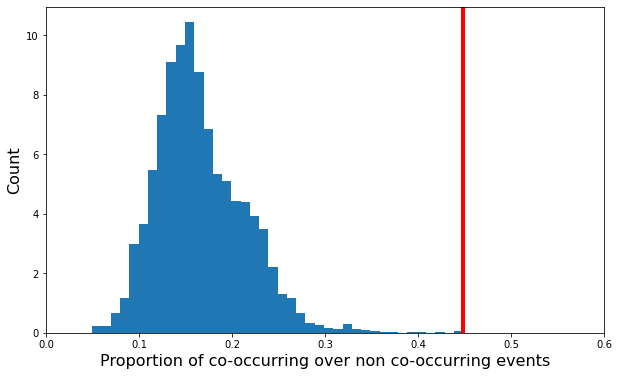

In [20]:
# Plot pdf
import scipy.stats as st
fig, ax = plt.subplots(figsize=(10,6)) 
plt.hist(proportion_rand, density=True, bins=40, label="Proportion of THWs with co-occurring MHWs")
plt.xlim(xmin=0, xmax = 0.6)
plt.axvline(x=prop, color='r', linewidth=4)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Proportion of co-occurring over non co-occurring events', fontsize=16)